In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import sys
sys.path.insert(0,'../')
import pyathena as pa
from pyathena import preprocessing

In [4]:
base='/tigress/changgoo/'
pids=['R2_2pc_metal','R4_4pc_metal','R8_8pc_metal','R16_16pc_metal','LGR2_2pc_metal','LGR4_4pc_metal','LGR8_8pc_metal']

In [5]:
# run below if there is no hst_zp.p file

#for pid in pids:
#    preprocessing.doall(base,pid,problem_dir=pid,do_pickling=False)

In [6]:
import cPickle as p

hsts={}
pars={}
for pid in pids:
    hstzp_filename='{}{}/hst/{}.hst_zp.p'.format(base,pid,pid)
    hsts[pid]=p.load(open(hstzp_filename))
    par_filename='{}{}/{}.par'.format(base,pid,pid)
    pars[pid]=pa.get_params(par_filename)

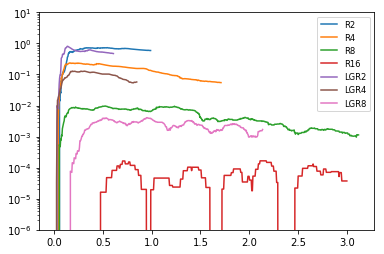

In [7]:
for pid in pids:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    torb=2*np.pi/p['Omega']
    plt.semilogy(h.index/torb,h['sfr100'],label=model)
plt.ylim(1.e-6,10)
plt.legend(fontsize='small')

In [8]:
from pyathena.set_plt import labels,label_units

In [9]:
surf_min={'R2':70,'R4':35,'R8':9,'R16':2.4,'LGR2':70,'LGR4':35,'LGR8':9,}
surf_max={'R2':90,'R4':45,'R8':11,'R16':2.6,'LGR2':90,'LGR4':45,'LGR8':11}

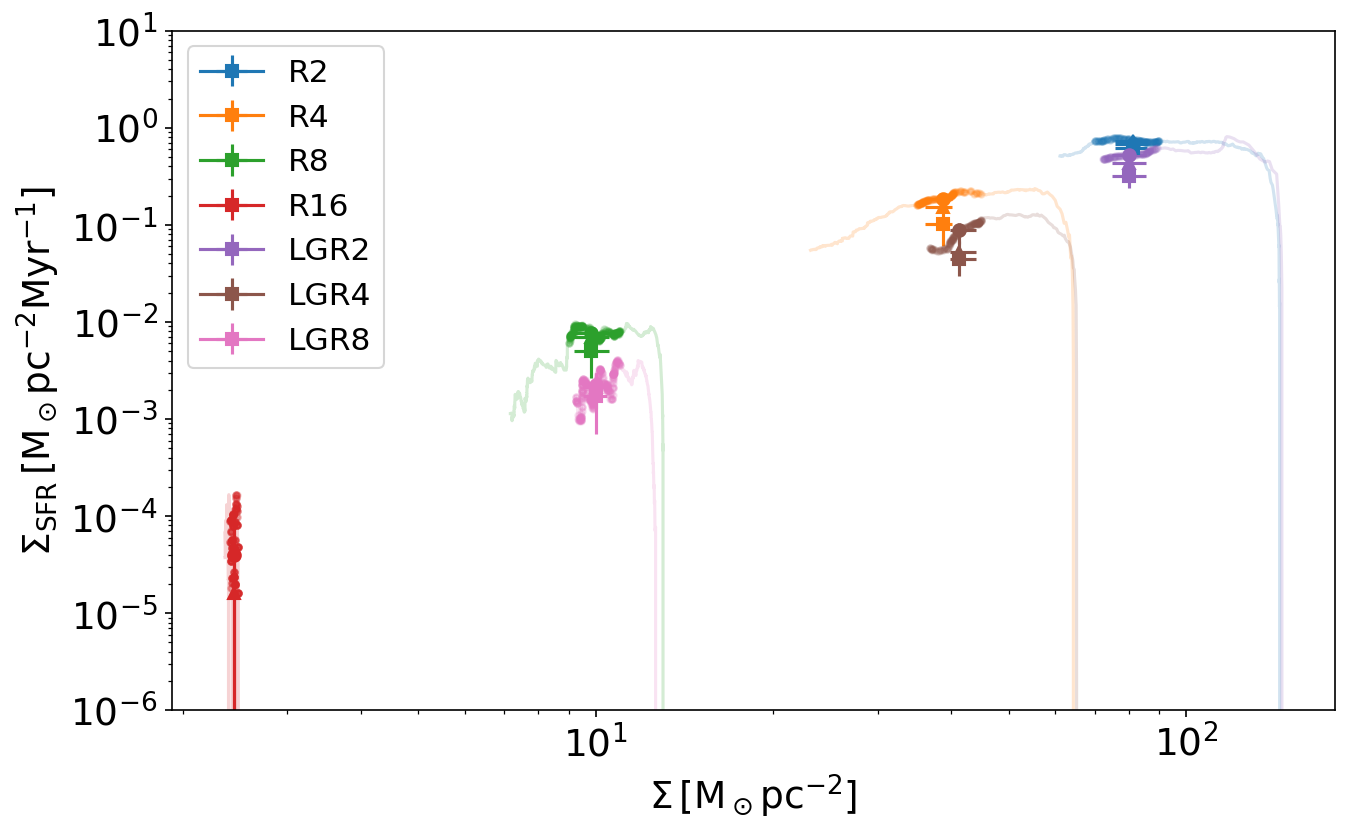

In [11]:
legend_items=[]

xf='surf'
yf='sfr40'

for pid in pids:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    
    l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
    
    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
    plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=model,alpha=0.2)
    
    # calculate 10, 50, 90 percentiles
    for m,yf in zip(['s','^','o'],['sfr10','sfr40','sfr100']):
        x=np.percentile(h[xf],[25,50,75])
        y=np.percentile(h[yf],[25,50,75])
        yerr=np.diff(y).reshape(2,1)
        xerr=np.diff(x).reshape(2,1)
        points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                            color=l.get_color(),marker=m,label=model)
        if yf is 'sfr10': legend_items.append(points)

plt.ylim(1.e-6,10)
plt.xlabel(labels['surf']+label_units['surf'])
plt.ylabel(labels['sfr']+label_units['sfr'])
plt.legend(handles=legend_items,fontsize='small')

### Pressures

* `Pmid_2p`: total midplane pressure
* `W_2p`: weight of 2p gas directly calculated by integrating $\rho g_z$
* `PDE`: dynamical equilibrium pressure based on the numerically calculated $\chi=4\zeta_d \rho_{\rm sd}/\rho_0$
* `PDE2`: DE pressure based on the analytic expressions with $\sigma_z$ from the simulation

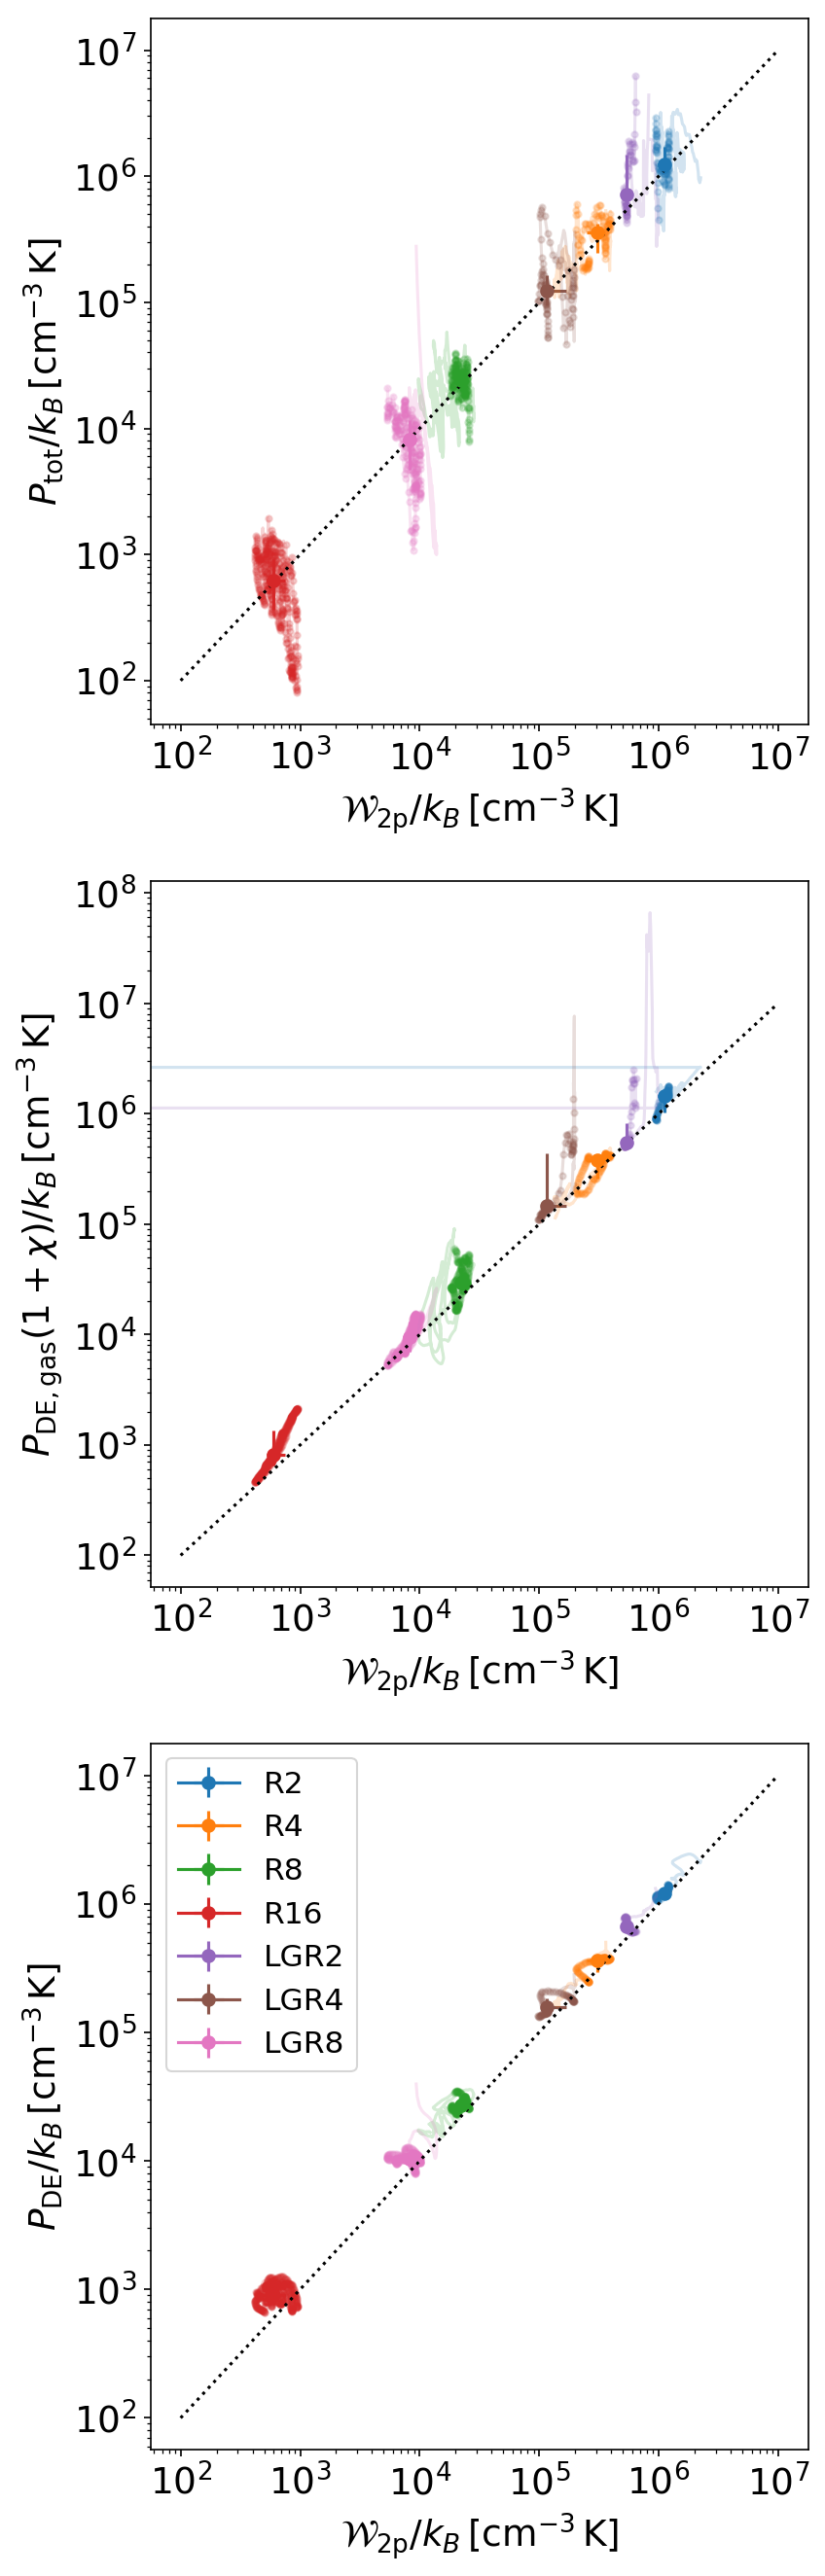

In [13]:
fig=plt.figure(figsize=(6,18))
for i,yf in enumerate(['Pmid_2p','PDE','PDE2']):
    plt.subplot(3,1,i+1)
    legend_items=[]
    xf='W_2p'

    for pid in pids:
        h=hsts[pid]
        p=pars[pid]
        model=pid.split('_')[0]

        l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)

        # selecting ranges based on the surface density
        idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
        h=h[idx]
        plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=model,alpha=0.2)

        # calculate 10, 50, 90 percentiles
        x=np.percentile(h[xf],[25,50,75])
        y=np.percentile(h[yf],[25,50,75])
        yerr=np.diff(y).reshape(2,1)
        xerr=np.diff(x).reshape(2,1)
        points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                            color=l.get_color(),marker=m,label=model)
        legend_items.append(points)

    plt.ylabel(labels[yf]+'/$k_B$'+label_units['pressure'])
    plt.xlabel(labels['W_2p']+'/$k_B$'+label_units['pressure'])
    plt.plot([100,1.e7],[100,1.e7],':k')
plt.legend(handles=legend_items,fontsize='small')
plt.tight_layout()

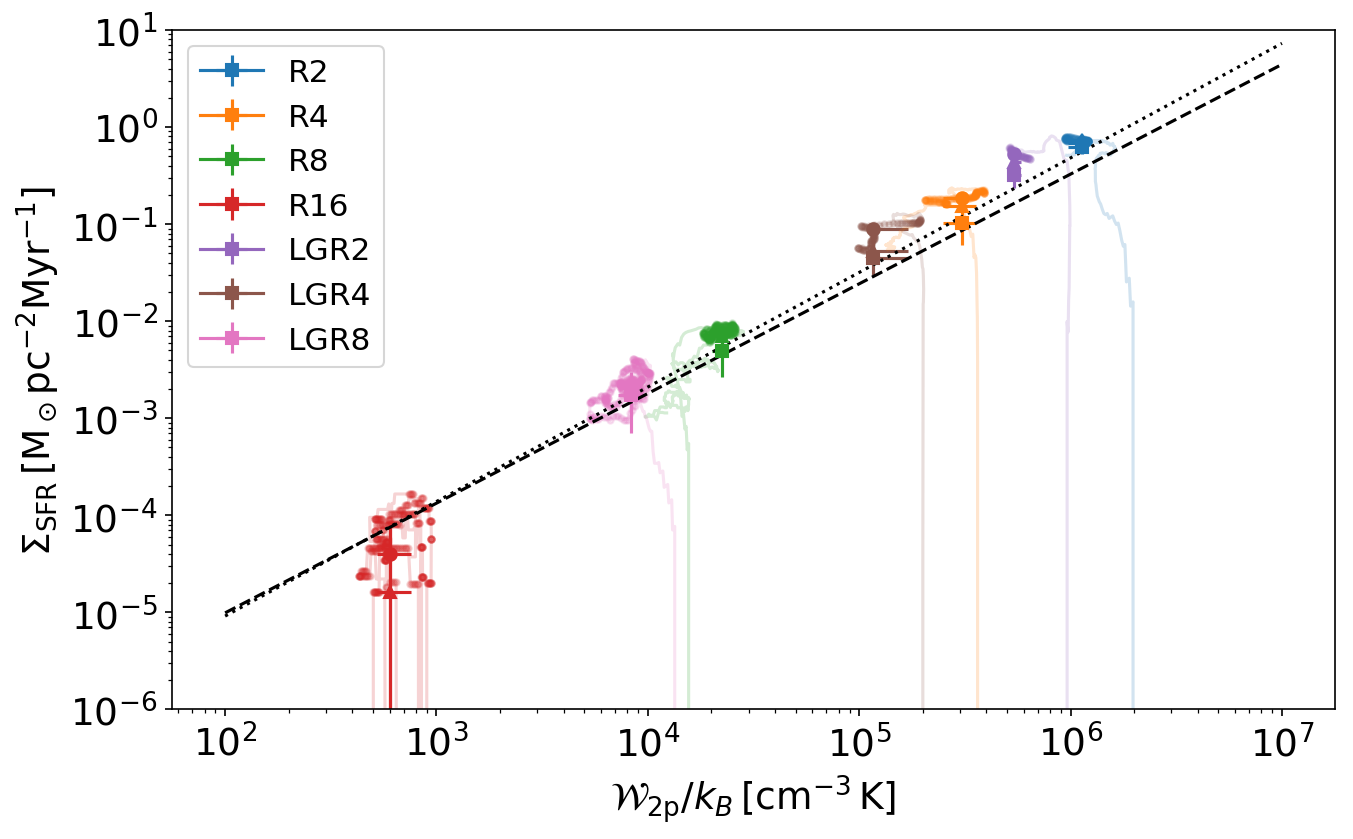

In [14]:
legend_items=[]
xf='W_2p'
yf='sfr40'

for pid in pids:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    
    l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
    
    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
    plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=model,alpha=0.2)
    
    # calculate 10, 50, 90 percentiles
    for m,yf in zip(['s','^','o'],['sfr10','sfr40','sfr100']):
        x=np.percentile(h[xf],[25,50,75])
        y=np.percentile(h[yf],[25,50,75])
        yerr=np.diff(y).reshape(2,1)
        xerr=np.diff(x).reshape(2,1)
        points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                            color=l.get_color(),marker=m,label=model)
        if yf is 'sfr10': legend_items.append(points)

Pfit=np.logspace(2,7,100)
plt.plot(Pfit,2.1e-3*(Pfit/1.e4)**1.18,':k') # KOK13 Eq. (26) -- fit to Ptot
plt.plot(Pfit,1.8e-3*(Pfit/1.e4)**1.13,'--k') # KOK13 Eq. (27) -- fit to PDE
plt.ylim(1.e-6,10)
plt.xlabel(labels['W_2p']+'/$k_B$'+label_units['pressure'])
plt.ylabel(labels['sfr']+label_units['sfr'])
plt.legend(handles=legend_items,fontsize='small')

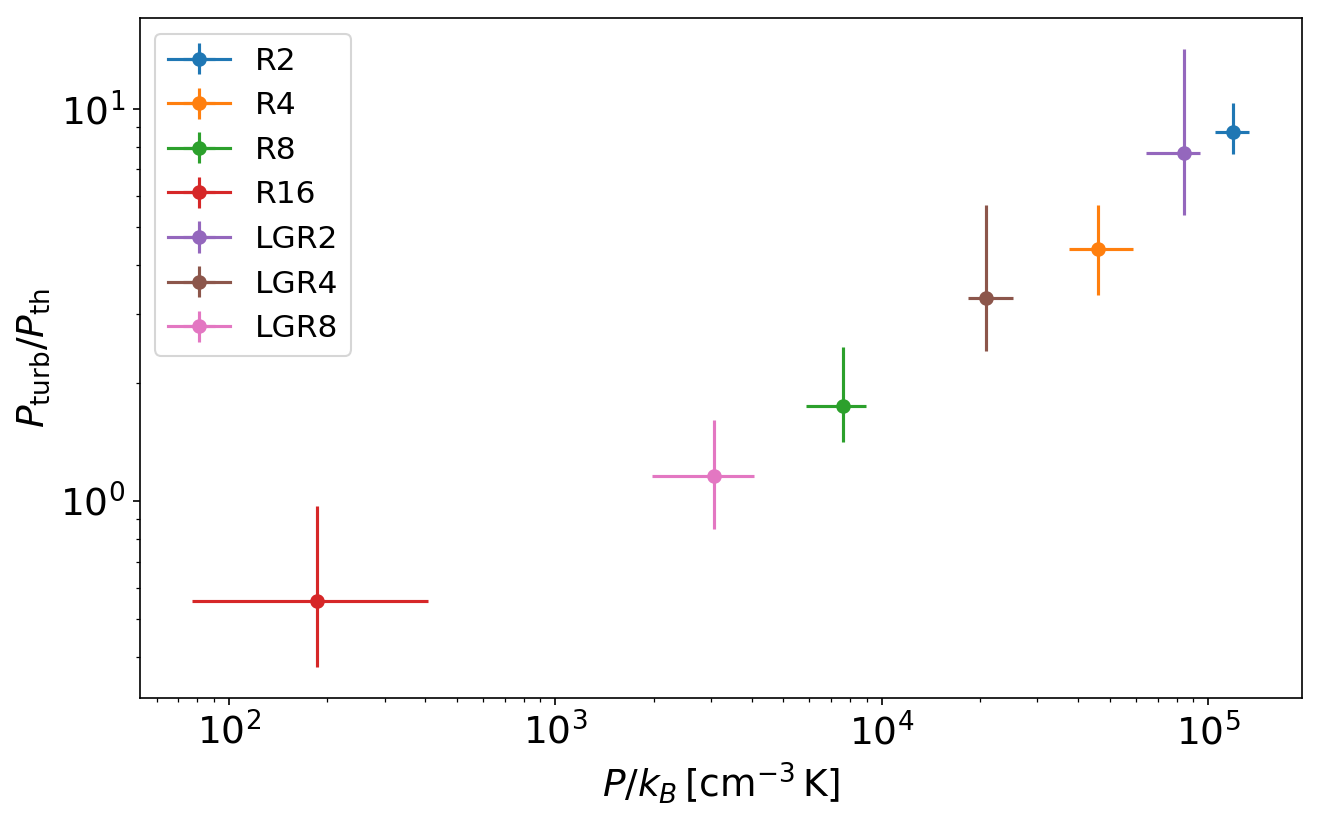

In [16]:
legend_items=[]
xf='Pth_mid_2p'
yf='Pturb_mid_2p'

for pid in pids:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]

    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
    #plt.plot(h[xf],h[yf]/h[xf],'.',color=l.get_color(),label=model,alpha=0.2)
    
    # calculate 10, 50, 90 percentiles
    x=np.percentile(h[xf],[25,50,75])

    y=np.percentile(h[yf]/h[xf],[25,50,75])

    yerr=np.diff(y).reshape(2,1)
    xerr=np.diff(x).reshape(2,1)
    points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                        marker=m,label=model)
    legend_items.append(points)


plt.xlabel(labels['Pth']+label_units['pressure'])
plt.ylabel(labels['Pturb_mid_2p']+'/'+labels['Pth_mid_2p'])
plt.xscale('log')
plt.yscale('log')
plt.legend(handles=legend_items,fontsize='small')

In [22]:
# calculate reference values
pid='R8_8pc_metal'
h=hsts[pid]
model=pid.split('_')[0]

idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model]) & (h['sfr10'] != 0)
h=h[idx]

eta_th=(h['Pth_mid_2p']/1.e3)/(h['sfr10']/1.e-3)
eta_turb=(h['Pturb_mid_2p']/1.e3)/(h['sfr10']/1.e-3)
eta_th0=np.percentile(eta_th,50)
eta_turb0=np.percentile(eta_turb,50)
nmid0=np.percentile(h['nmid'],50)
#eta_th0=eta_th.mean()
#eta_turb0=eta_turb.mean()
#nmid0=nmid.mean()
print eta_th0,eta_turb0,nmid0

1.49334815466 2.88276051714 0.530064935684


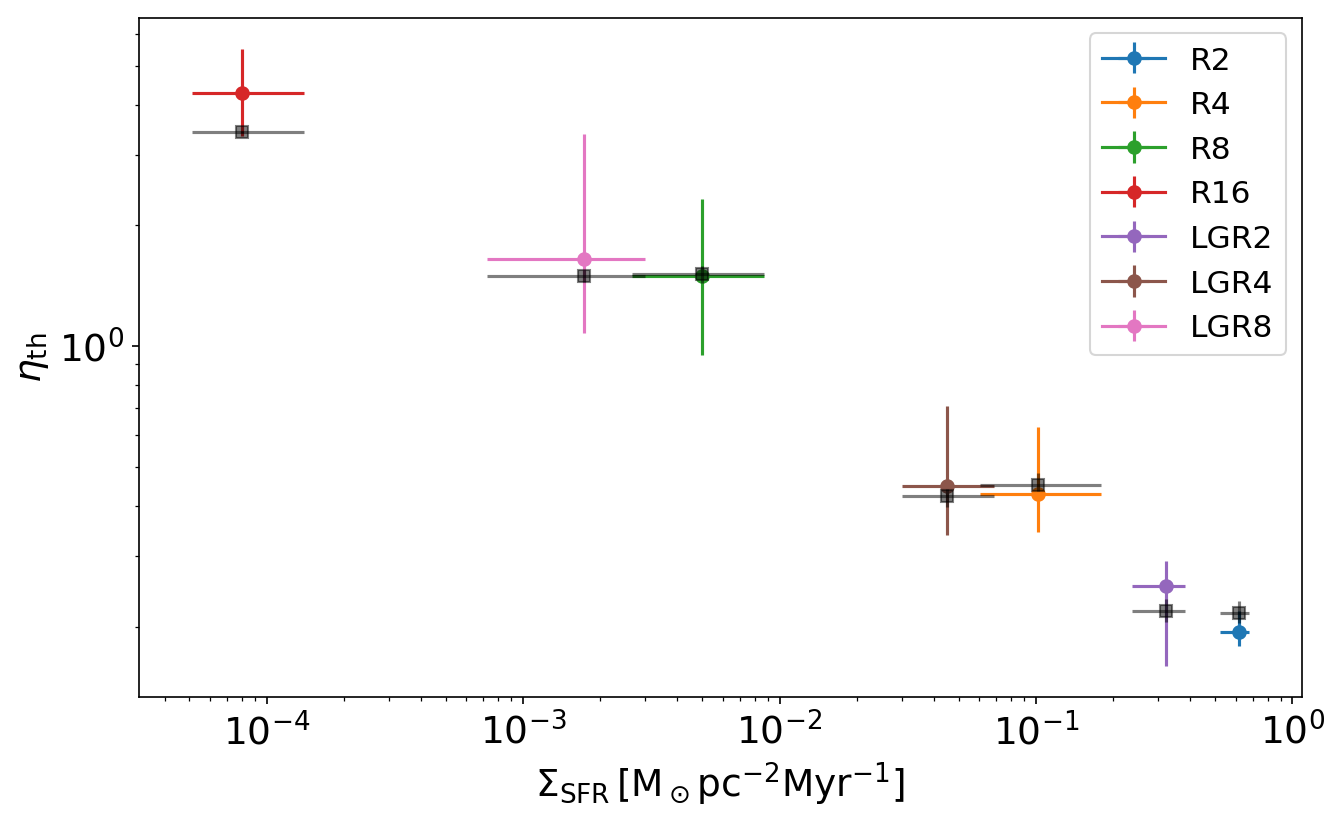

In [24]:
legend_items=[]
xf='sfr10'
yf='Pth_mid_2p'

set_norm=False
sfr=[]
ftau=[]
for pid in pids:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]

    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model]) & (h['sfr40'] > 1.e-10)
    h=h[idx]
    if pid is 'R16_16pc_metal':
        xf='sfr40'
    else:
        xf='sfr10'
    #plt.plot(h[xf],h[yf]/h[xf],'.',color=l.get_color(),label=model,alpha=0.2)
    
    # calculate 10, 50, 90 percentiles
    x=np.percentile(h[xf],[25,50,75])
    eta=(h[yf]/1.e3)/(h[xf]/1.e-3)
    
    y=np.percentile(eta,[25,50,75])
    yerr=np.diff(y).reshape(2,1)
    xerr=np.diff(x).reshape(2,1)
        
    points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                        marker='o',label=model,zorder=-1)
    legend_items.append(points)
    
    y2=np.percentile(eta_th0*h['ftau_hst'],[25,50,75])
    y2err=np.diff(y2).reshape(2,1)

    points=plt.errorbar(x[1],y2[1],yerr=y2err,xerr=xerr,
                        marker='s',label=model,color='k',alpha=0.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel(labels['sfr']+label_units['sfr'])
plt.ylabel(r'$\eta_{\rm th}$')
plt.legend(handles=legend_items,fontsize='small')

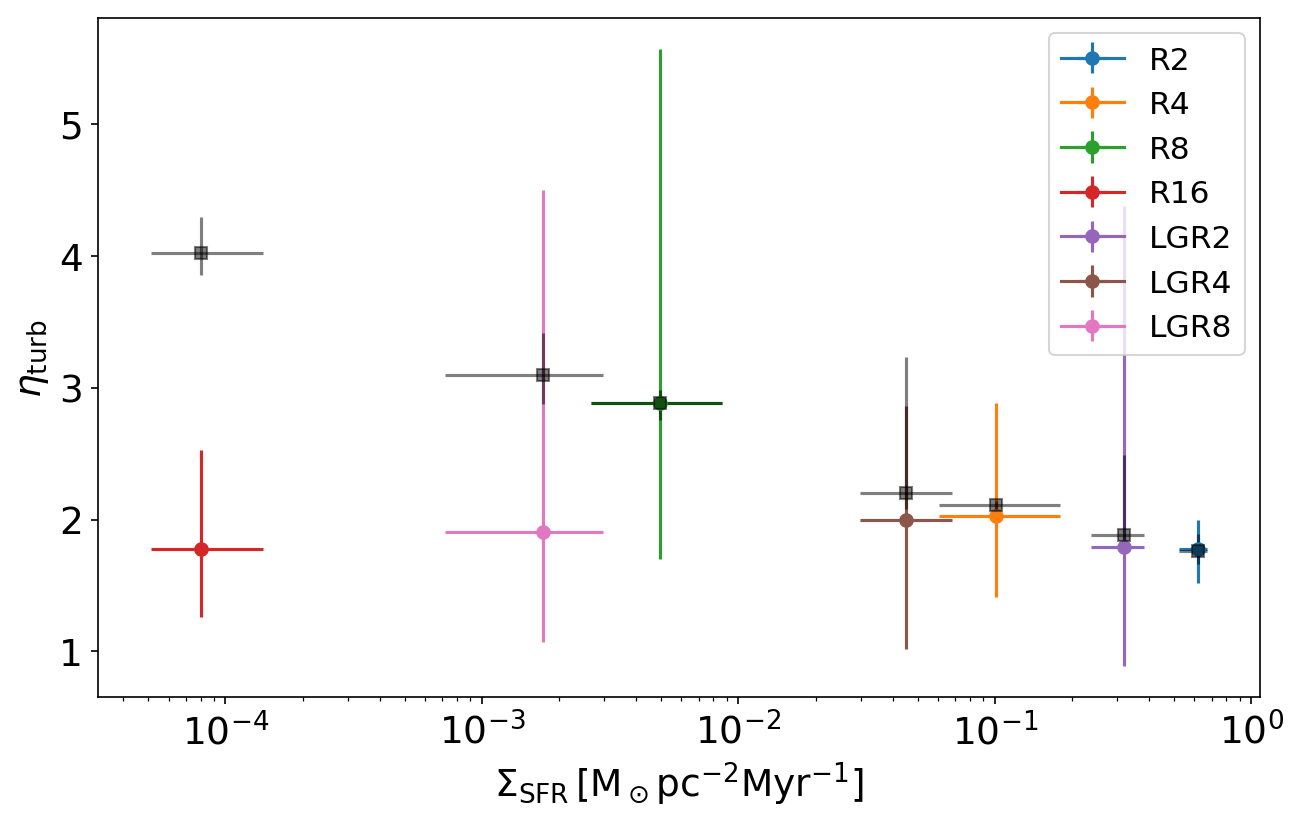

In [26]:
legend_items=[]
xf='sfr10'
yf='Pturb_mid_2p'

set_norm=False
sfr=[]
nmid=[]
for pid in pids:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]

    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model]) & (h['sfr40'] > 1.e-10)
    h=h[idx]
    if pid is 'R16_16pc_metal':
        xf='sfr40'
    else:
        xf='sfr10'
    
    # calculate 10, 50, 90 percentiles
    x=np.percentile(h[xf],[25,50,75])
    eta=(h[yf]/1.e3)/(h[xf]/1.e-3)

    y=np.percentile(eta,[25,50,75])
    yerr=np.diff(y).reshape(2,1)
    xerr=np.diff(x).reshape(2,1)

    points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                        marker=m,label=model)
    legend_items.append(points)

    y2=np.percentile(eta_turb0*(h['nmid']/nmid0)**(-0.17),[25,50,75])
    y2err=np.diff(y2).reshape(2,1)

    points=plt.errorbar(x[1],y2[1],yerr=y2err,xerr=xerr,
                        marker='s',label=model,color='k',alpha=0.5)

plt.xscale('log')
plt.xlabel(labels['sfr']+label_units['sfr'])
plt.ylabel(r'$\eta_{\rm turb}$')
plt.legend(handles=legend_items,fontsize='small')